<h1>Final Project - Tweet Sentiment Analysis</h1>

<b>No. 4 / Friday Data Team</b>
(Simiao Wang, Nijia Wu, Mengyun Xie, Yaokun Ren)

<b>Overview</b>

Twitter Sentiment Analysis involves analyzing text data from Twitter to determine the sentiment expressed in each tweet. The core objective is to categorize tweets into three sentiment classes: negative (-1), neutral (0), and positive (1). This classification reflects the emotional tone or attitude conveyed in the tweet regarding a topic, person, or entity.

<b>Significance of the Problem</b>

* Business Insights: Companies can use sentiment analysis to gauge public opinion about their brand, products, or services.
* Market Analysis: It helps in understanding consumer behavior, preferences, and market trends.
* Political Campaigns: Political groups can monitor public sentiment about policies, campaigns, or public figures.
Social Research: It provides insights into public mood and societal issues, useful in social science research.

<b>Data Attributes</b>: 
* clean_text - Message Tweeted
* category - Sentiment for the tweet, negative(-1), neutral(0), and positive(+1).

<h1>1. Data Collection and Preprocessing</h1>

<h2>1.1 Loading the dataset</h2>

In [1]:
# Importing Packages
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from PIL import Image
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import urllib.request
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec

In [2]:
# Reading Data
# Download from: https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset

df = pd.read_csv('Twitter_Data.csv')

In [3]:
df.sample(5)

,clean_text,category
78246,agree forced conversions should stopped bur yo...,1.0
120454,seen that london what law iniciat for nilesh m...,-1.0
102412,this guy and his boss modi would have been the...,1.0
14863,the biggest shock for would know one fulfilled...,0.0
55836,lok sabha elections live news jaitley says mod...,1.0


In [4]:
# Checking for NA Values
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [5]:
# Distribution of different classes in sentiment
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])
count_values_in_column(df,"category")

,Total,Percentage
1.0,72250,44.33
0.0,55213,33.88
-1.0,35510,21.79
NaN,7,0.00


In [6]:
# Segrating based on different sentiments
df_negative = df[df["category"]==-1]
df_positive = df[df["category"]==1]
df_neutral = df[df["category"]==0]

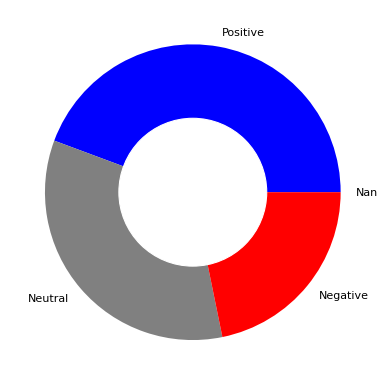

In [7]:
# create data for Pie Chart
plt.figure(figsize=(6, 6), dpi=80)
pichart = count_values_in_column(df,"category")
names= ["Positive","Neutral","Negative","Nan"]
size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['blue','grey','red',"purple"])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

<Axes: xlabel='category', ylabel='count'>

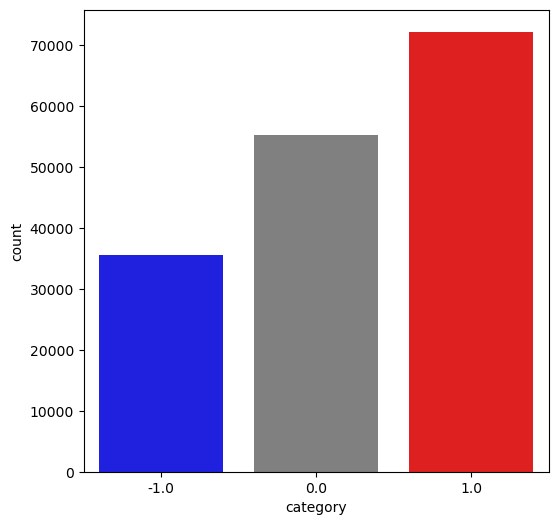

In [8]:
plt.figure(figsize=(6,6))
colors=['blue','grey','red']
sns.countplot(x=df['category'], palette=colors)

In [9]:
# Function to Create Wordcloud
def create_wordcloud(text,path):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    max_words=3000,
    stopwords=stopwords,
    random_state=42,
    width=900, height=500,
    repeat=True)
    
    wc.generate(str(text))
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    path=path
    display(Image.open(path))

Word Cloud Saved Successfully


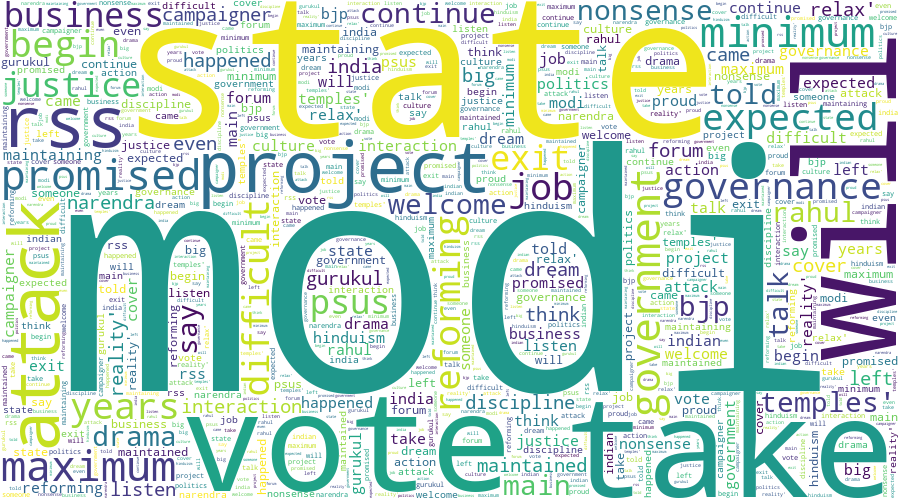

<Figure size 1200x640 with 0 Axes>

In [10]:
# Wordcloud for all tweets
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df['clean_text'].values,"all.png")

Word Cloud Saved Successfully


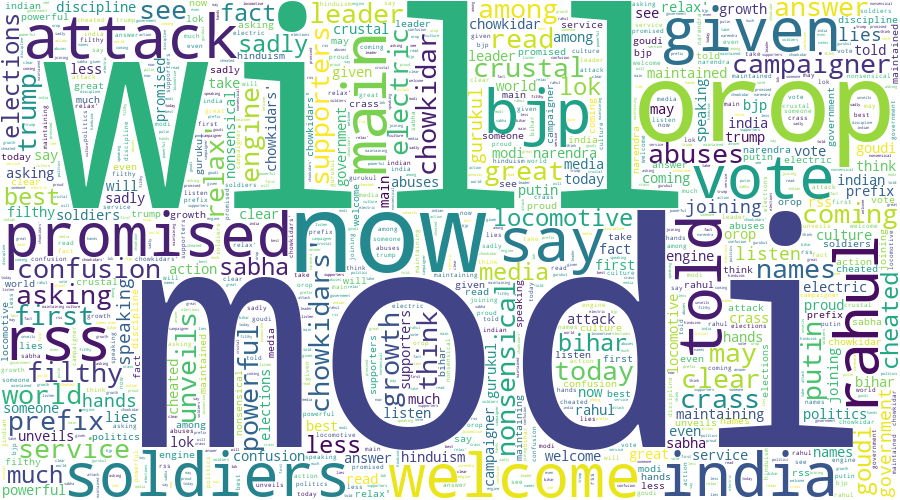

<Figure size 1200x640 with 0 Axes>

In [11]:
# Wordcloud for only positive tweets
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df_positive['clean_text'].values,"positive.png")

Word Cloud Saved Successfully


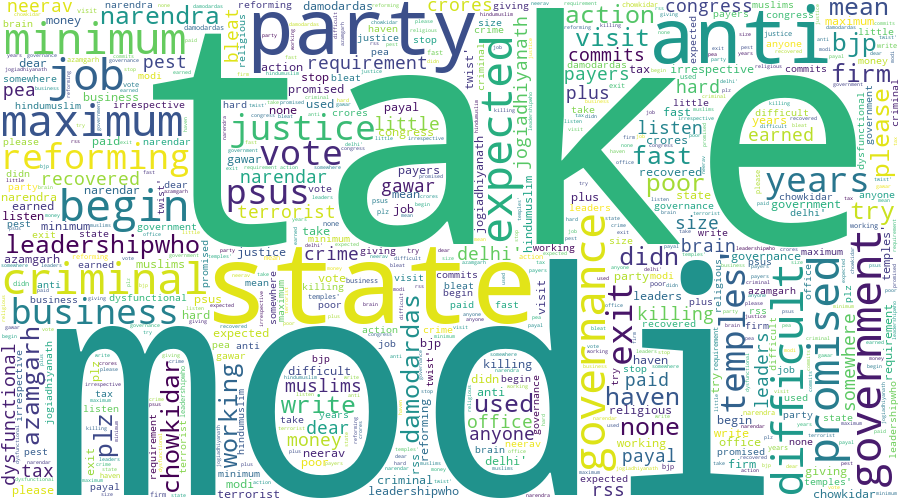

<Figure size 1200x640 with 0 Axes>

In [12]:
# Wordcloud for only negative tweets
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df_negative['clean_text'].values,"negative.png")

Word Cloud Saved Successfully


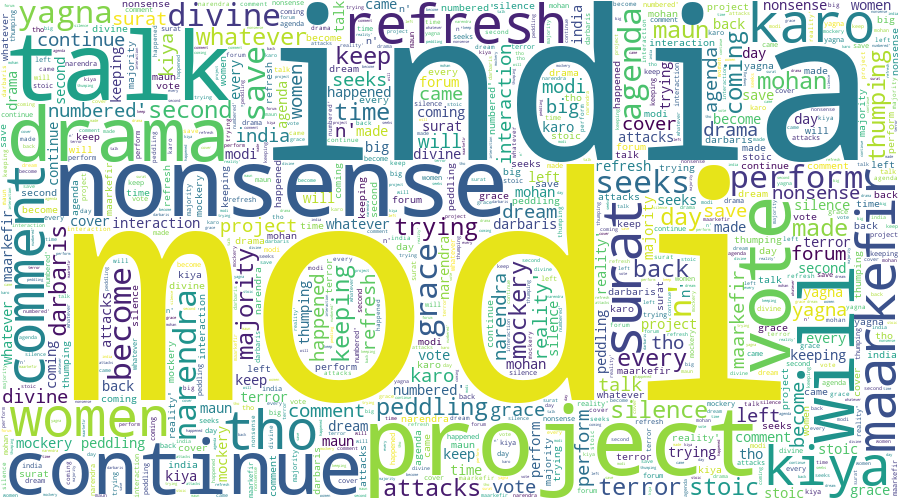

<Figure size 1200x640 with 0 Axes>

In [13]:
# Wordcloud for only neutral tweets
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df_neutral['clean_text'].values,"neutral.png")

<h2>1.2 Data Preprocessing</h2>

<b>Framing the Problem in the Context of Machine Learning</b>

This problem is best framed as a Supervised Learning task, and the reasons are below:
* Labeled Data: The dataset contains labeled examples (tweets with corresponding sentiment labels).
* Classification Task: The objective is to classify each tweet into one of the predefined categories (negative, neutral, positive), making it a classic classification problem.
* Predictive Modeling: The goal is to train a model on historical data (past tweets and their sentiments) so that it can predict the sentiment of new, unseen tweets.

<b>Data Normalization</b>

Tweets are inherently unstructured and can contain various forms of text (emojis, hashtags, links). Normalizing this text to a consistent format is vital for analysis. Common steps include converting all text to lower case, removing special characters, URLs, and numbers, and possibly replacing or removing emojis and hashtags.

We follow the below processes to do the data normalization:

* Tokenization — convert sentences to words
* Removing unnecessary punctuation, tags
* Removing stop words — frequent words such as ”the”, ”is”, etc. that do not have specific semantic
* Converting all letters to lower case
* Stemming — words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.

In [14]:
# Stemming
ps = PorterStemmer()
# Initializing Lists
corpus = []
words = []
for i in range(0, len(df)):
    # Removing characters other than letters
    review = re.sub('[^a-zA-Z]', ' ', str(df["clean_text"][i]))
    # Lowering the case all the text
    review = review.lower()
    # Splitting into words
    review = review.split()
    # Applying Stemming
    stemmed = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    # Joining words
    review = ' '.join(stemmed)
    # Appending all tweets to a list after preprocessing
    corpus.append(review)
    # Appending all words for word embeddings
    words.append(stemmed)

In [15]:
# Corpus sample
corpus[1:10]

['talk nonsens continu drama vote modi',
 'say vote modi welcom bjp told rahul main campaign modi think modi relax',
 'ask support prefix chowkidar name modi great servic confus read crustal clear crass filthi nonsens see abus come chowkidar',
 'answer among power world leader today trump putin modi may',
 'kiya tho refresh maarkefir comment karo',
 'surat women perform yagna seek divin grace narendra modi becom',
 'come cabinet scholar like modi smriti hema time introspect',
 'upcom elect india saga go import pair look current modi lead govt elect deal brexit combin weekli look juici bear imho',
 'gandhi gay modi']

In [16]:
# Length 
print("Legth of Corpus:",len(corpus))

Legth of Corpus: 162980


In [17]:
# Updating created corpus in our dataframe
df["clean_text"] = corpus

<b>Handling Missing Values</b>

In our case, missing proportion is small and those missing values are not 			 substantial for our analysis and removal is straightforward but can lead to loss of valuable data, so we used imputation maintains data integrity but might introduce bias.

In [18]:
# Dropping NA Values and resetting index
df = df.dropna()
df = df.reset_index()

In [19]:
# Checking for NA Values after corpus updations
df.isna().sum()

index         0
clean_text    0
category      0
dtype: int64

In [20]:
# Exporting stemmed sentences
df[["clean_text","category"]].to_csv("stemmed.csv",index = False)

In [21]:
# Loading the stemmed sentences
df_stemmed = pd.read_csv("stemmed.csv")
# Extracting corpus
corpus = list(df_stemmed["clean_text"])

In [22]:
# Plot the frequence of the unique words 

all_words = " ".join([sentence for sentence in df['clean_text']])
all_words = all_words.split()

freq_dict = {}
for word in all_words:
    # set the default value to 0
    freq_dict.setdefault(word, 0)
    # increment the value by 1
    freq_dict[word] += 1

82091


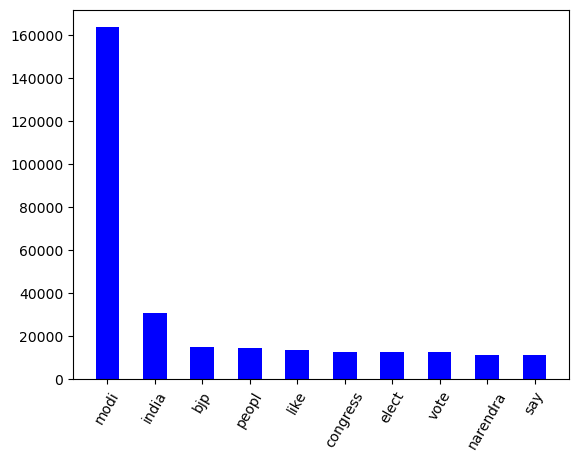

In [23]:
import itertools

voc_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))
print(len(voc_freq_dict))
hist_plot = dict(itertools.islice(voc_freq_dict.items(), 10))
plt.bar(hist_plot.keys(), hist_plot.values(), width=0.5, color='blue')
plt.xticks(rotation=60)
plt.show()

<h2>1.3 Feature Extraction</h2>

In text processing, words of the text represent discrete, categorical features. How do we encode such data in a way which is ready to be used by the algorithms? The mapping from textual data to real valued vectors is called feature extraction. One of the simplest techniques to numerically represent text is Bag of Words & TFIDF Vectorizer.

TF-IDF Vectorizer:
Here, we use TF-IDF Vectorizer for vectorization.The algorithm Term Frequency & Inverse Document Frequency.

Term Frequency (TF) = (Number of times term t appears in a document)/(Number of terms in the document)

Inverse Document Frequency (IDF) = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in. The IDF of a rare word is high, whereas the IDF of a frequent word is likely to be low. Thus having the effect of highlighting words that are distinct.

We can calculate TF-IDF value of a term as = TF * IDF

In [24]:
# Applying TFIDF Vectorization
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(df["clean_text"]).toarray()

In [25]:
# Independent Variable
X = df_stemmed["clean_text"]
# Dependent Varible
Y=df_stemmed["category"]

In [26]:
#update scikit-learn version if error
df_tfidf = pd.DataFrame(X_tfidf,columns = tfidf.get_feature_names_out())
df_tfidf["output"] = Y
df_tfidf.head()

,aadhaar,aadhar,aaj,aam,aap,aayega,aayog,abdullah,abe,abhi,...,youngster,your,youth,youtub,youv,yr,yr modi,zee,zero,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<h2>1.4 Split the dataset</h2>

Use 70% of the data for training, 15% for validation, and 15% for testing.

In [27]:
x_train_df, x_test_df = train_test_split(X_tfidf, test_size=0.3, random_state=42)
x_valid_df, x_test_df = train_test_split(x_test_df, test_size=0.5, random_state=42)
print(x_train_df.shape,x_valid_df.shape,x_test_df.shape)

y_train_df, y_test_df = train_test_split(Y, test_size=0.3, random_state=42)
y_valid_df, y_test_df = train_test_split(y_test_df, test_size=0.5, random_state=42)
print(y_train_df.shape,y_valid_df.shape,y_test_df.shape)

(114081, 5000) (24446, 5000) (24446, 5000)
(114081,) (24446,) (24446,)


<h1>2. Model Selection, Evaluation and Interpretation</h1>

In this project, we chose 3 suitable models for the following reasons:

<b>1. Naive Bayes: </b>
This is a probabilistic model that assigns a probability that a text belongs to a certain class, based on the frequency of words in the text.
* It is easy to implement and fast to train and predict.
* It can handle high-dimensional and categorical data, which is like our case.
* It can avoid overfitting by using smoothing techniques.

<b>2.Logistic Regression: </b>
This is a statistical model that predicts a categorical value (such as a score) based on the features of the text, such as word counts or TF-IDF values.
* It is easy to implement, interpret and train.
* It can handle multi-class classification problems.
* It can provide a natural probabilistic view of class predictions.
* It can interpret model coefficients as indicators of feature importance.

<b>3.Support Vector Machines (SVM): </b>
This is a model that finds the optimal hyperplane that separates the classes of texts, based on a kernel function that measures the similarity between texts. 
* It can handle non-linear and high-dimensional data.
* It is robust to noise and outliers.

Here, we will use two metrics (accuracy_score and confusion_matrix) to evaluate our model.
* `accuracy_score` is the ratio of the correct predicted value to the total predicted value. It tells us how accurate our predictions are.
* `confusion_matrix` is a table that provides a summary of the performance of a classification algorithm. It is particularly useful in evaluating the performance of a model by comparing the predicted and true values for different classes.

<h2>2.1 Multinomial Naive Bayes</h2>

<h3>2.1.1 Model Building</h3>

In [28]:
# Initializing MultinomialNB Model
nb_model = MultinomialNB(alpha=0.1)
# Fitting data
nb_model.fit(x_train_df,y_train_df)
# Prediction on test data
y_pred_nb = nb_model.predict(x_valid_df)

# Evaluation Metrics
acc_nb = accuracy_score(y_valid_df,y_pred_nb)
classification_nb = classification_report(y_valid_df,y_pred_nb)
confusion_matrix_nb = confusion_matrix(y_valid_df,y_pred_nb)

# Print result
print("Mutinomial Naive Bayes:")
print(f"Accuracy: {acc_nb:.4f}")
print("Classification: \n",classification_nb)
print("Confusion matrix: \n",confusion_matrix_nb)

Mutinomial Naive Bayes:
Accuracy: 0.7083
Classification: 
               precision    recall  f1-score   support

        -1.0       0.78      0.47      0.58      5400
         0.0       0.76      0.66      0.71      8224
         1.0       0.67      0.87      0.75     10822

    accuracy                           0.71     24446
   macro avg       0.74      0.66      0.68     24446
weighted avg       0.72      0.71      0.70     24446

Confusion matrix: 
 [[2519  728 2153]
 [ 234 5428 2562]
 [ 475  979 9368]]


<h3>2.1.2 Hyperparameter tuning</h3>

In [35]:
# Define the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Define hyperparameters and their possible values
param_grid_nb = {
    'alpha': [0.0001, 0.01, 1]
}

# Create GridSearchCV object
grid_search_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_nb.fit(x_train_df, y_train_df)

# Get the best parameters and the best model
best_params_nb = grid_search_nb.best_params_
best_model_nb = grid_search_nb.best_estimator_

# Use the best model to make predictions on the validation set
y_pred_nb = best_model_nb.predict(x_valid_df)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params_nb)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'alpha': 0.0001}


<h3>2.1.3 Evaluation and Interpretation</h3>

In [36]:
# Evaluate the performance of the model
acc_nb = accuracy_score(y_valid_df, y_pred_nb)
classification_nb = classification_report(y_valid_df, y_pred_nb)
confusion_matrix_nb = confusion_matrix(y_valid_df, y_pred_nb)

In [37]:
# Print the evaluation metrics
print("Accuracy:", acc_nb)
print("Classification Report:\n", classification_nb)

Accuracy: 0.709441217377076
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.78      0.47      0.59      5400
         0.0       0.76      0.66      0.71      8224
         1.0       0.67      0.87      0.75     10822

    accuracy                           0.71     24446
   macro avg       0.74      0.67      0.68     24446
weighted avg       0.72      0.71      0.70     24446



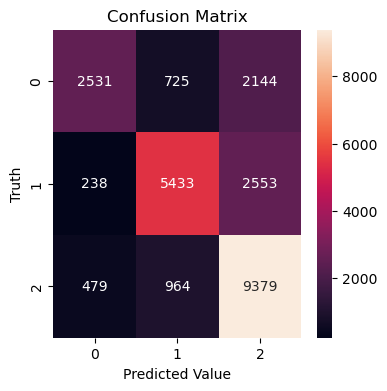

In [38]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_nb,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

After hyperparameter tuning, the best accuracy of Multinomial Naive Bayes model is 70.9%

<h2>2.2 Support Vector Machines (SVM)</h2>

<h3>2.2.1 Model Building</h3>

In [39]:
#Initializing the linear SVM Model
svm_model = SGDClassifier(loss='hinge',max_iter=500,random_state=42)
# Fitting data
svm_model.fit(x_train_df,y_train_df)
# Prediction on test data
y_pred_svm = svm_model.predict(x_valid_df)

# Evaluation Metrics
acc_svm = accuracy_score(y_valid_df,y_pred_svm)
classification_svm = classification_report(y_valid_df,y_pred_svm)
confusion_matrix_svm = confusion_matrix(y_valid_df,y_pred_svm)

# Print result
print("Support Vector Machines (SVM):")
print(f"Accuracy: {acc_svm:.4f}")
print("Classification: \n",classification_svm)
print("Confusion matrix: \n",confusion_matrix_svm)

Support Vector Machines (SVM):
Accuracy: 0.8066
Classification: 
               precision    recall  f1-score   support

        -1.0       0.83      0.61      0.70      5400
         0.0       0.74      0.93      0.82      8224
         1.0       0.87      0.81      0.84     10822

    accuracy                           0.81     24446
   macro avg       0.81      0.78      0.79     24446
weighted avg       0.82      0.81      0.80     24446

Confusion matrix: 
 [[3275 1193  932]
 [ 166 7666  392]
 [ 511 1535 8776]]


<h3>2.2.2 Hyperparameter tuning</h3>

In [40]:
# Define the SVM model
svm_model = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

# Define hyperparameters and their possible values
param_grid_svm = {
    'alpha': [0.0001, 0.01, 1]
}

# Create GridSearchCV object
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_svm.fit(x_train_df, y_train_df)

# Get the best parameters and the best model
best_params_svm = grid_search_svm.best_params_
best_model_svm = grid_search_svm.best_estimator_

# Use the best model to make predictions on the validation set
y_pred_svm = best_model_svm.predict(x_valid_df)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params_svm)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'alpha': 0.0001}


<h3>2.2.3 Evaluation and Interpretation</h3>

In [41]:
# Evaluate the performance of the model
acc_svm = accuracy_score(y_valid_df, y_pred_svm)
classification_svm = classification_report(y_valid_df, y_pred_svm)
confusion_matrix_svm = confusion_matrix(y_valid_df, y_pred_svm)

In [42]:
# Print the evaluation metrics
print("Accuracy:", acc_svm)
print("Classification Report:\n", classification_svm)

Accuracy: 0.8065532193405874
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.83      0.61      0.70      5400
         0.0       0.74      0.93      0.82      8224
         1.0       0.87      0.81      0.84     10822

    accuracy                           0.81     24446
   macro avg       0.81      0.78      0.79     24446
weighted avg       0.82      0.81      0.80     24446



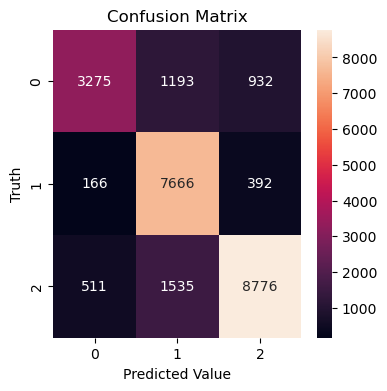

In [43]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_svm,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

After hyperparameter tuning, the best accuracy of Support Vector Machines model is 80.6%

<h2>2.3 Logistic Regression</h2>

<h3>2.3.1 Model Building</h3>

In [44]:
# Initializing Logistic Regression Model
lr_model = LogisticRegression(solver='liblinear')
# Fitting data
lr_model.fit(x_train_df,y_train_df)
# Prediction on test data
y_pred_lr = lr_model.predict(x_valid_df)

# Evaluation Metrics
acc_lr = accuracy_score(y_valid_df,y_pred_lr)
classification_lr = classification_report(y_valid_df,y_pred_lr)
confusion_matrix_lr = confusion_matrix(y_valid_df,y_pred_lr)

# Print result
print("Logistic Regression:")
print(f"Accuracy: {acc_lr:.4f}")
print("Classification: \n",classification_lr)
print("Confusion matrix: \n",confusion_matrix_lr)

Logistic Regression:
Accuracy: 0.8342
Classification: 
               precision    recall  f1-score   support

        -1.0       0.82      0.69      0.75      5400
         0.0       0.80      0.91      0.85      8224
         1.0       0.87      0.84      0.86     10822

    accuracy                           0.83     24446
   macro avg       0.83      0.82      0.82     24446
weighted avg       0.84      0.83      0.83     24446

Confusion matrix: 
 [[3734  801  865]
 [ 218 7519  487]
 [ 577 1106 9139]]


<h3>2.3.2 Hyperparameter tuning</h3>

In [45]:
# Define the Logistic Regression model
lr_model = LogisticRegression(solver='liblinear')

# Define hyperparameters and their possible values
param_grid_lr = {
    'max_iter': [100, 200, 500, 1000],
}

# Create GridSearchCV object
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_lr.fit(x_train_df, y_train_df)

# Get the best parameters and the best model
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

# Use the best model to make predictions on the validation set
y_pred_lr = best_model_lr.predict(x_valid_df)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params_lr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'max_iter': 100}


<h3>2.3.3 Evaluation and Interpretation</h3>

In [46]:
# Evaluate the performance of the model
acc_lr = accuracy_score(y_valid_df, y_pred_lr)
classification_lr = classification_report(y_valid_df, y_pred_lr)
confusion_matrix_lr = confusion_matrix(y_valid_df, y_pred_lr)

In [47]:
# Print the evaluation metrics
print("Accuracy:", acc_lr)
print("Classification Report:\n", classification_lr)

Accuracy: 0.8341650985846355
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.82      0.69      0.75      5400
         0.0       0.80      0.91      0.85      8224
         1.0       0.87      0.84      0.86     10822

    accuracy                           0.83     24446
   macro avg       0.83      0.82      0.82     24446
weighted avg       0.84      0.83      0.83     24446



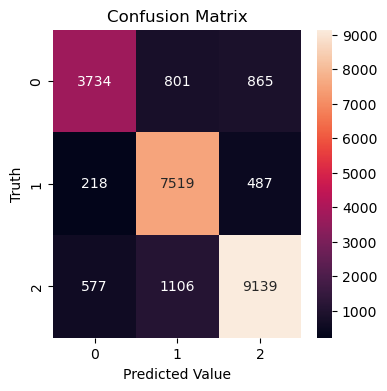

In [48]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_lr,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

After hyperparameter tuning, the best accuracy of Logistic Regression model is 83.4%

<h2>2.4 Model Compare</h2>

In [49]:
# Create a DataFrame for the accuracies of three best model
accuracy_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Multinomial Naive Bayes'],
    'Accuracy': [acc_lr, acc_svm, acc_nb]
})

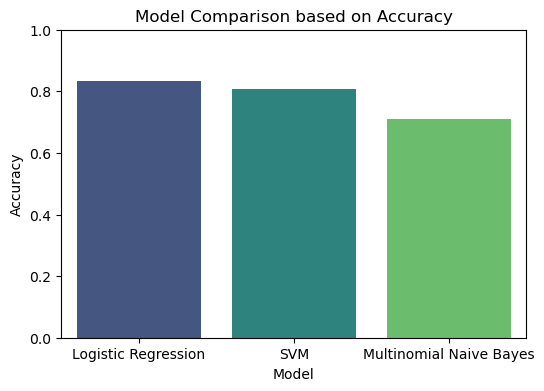

In [55]:
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')
plt.title('Model Comparison based on Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to be between 0 and 1 for accuracy
plt.show()

From the result, we can see the Logistic Regression model has best performance, and the best mode is `best_model_lr`.

<h2>2.4 Testing and Conclusion</h2>

<h3>2.4.1 Testing </h3>

In [51]:
# Prediction on test data
y_pred_test = best_model_lr.predict(x_test_df)

# Evaluate the performance of the model
acc_test = accuracy_score(y_test_df,y_pred_test)
classification_test = classification_report(y_test_df,y_pred_test)
confusion_matrix_test = confusion_matrix(y_test_df,y_pred_test)

In [52]:
# Print the evaluation metrics
print(f"Accuracy: {acc_test:.4f}")
print("Classification: \n",classification_test)

Accuracy: 0.8338
Classification: 
               precision    recall  f1-score   support

        -1.0       0.82      0.69      0.75      5397
         0.0       0.80      0.91      0.85      8206
         1.0       0.87      0.85      0.86     10843

    accuracy                           0.83     24446
   macro avg       0.83      0.82      0.82     24446
weighted avg       0.84      0.83      0.83     24446



The model gives us the best values for an accuracy score of 83.38% after tuning its hyperparameters.

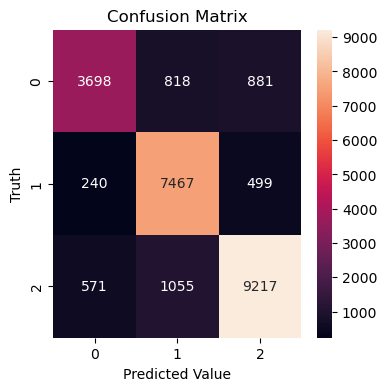

In [53]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_test,annot=True,fmt="d")
plt.title('Confusion Matrix')
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

In this graph, both the diagonal elements are high relative to the off-diagonal elements, it means that this model is performing well.

<h3>2.4.2 Conclusion </h3>

First, we built three different machine learning models: Multinomial Naive Bayes, Logistic Regression, and Support Vector Machines.

Then, we tuned the hyperparameters for each model individually. The tuning process aims to find the optimal set of hyperparameters to maximize accuracy and confusion matrices. We found that the Logistic Regression model exhibited the best overall performance.

we use the test set to further validate the performance of the best model. We calculated an accuracy score of 83.38% on the test set. This performance gives us confidence in the model's ability to generalize to real-world scenarios.